# Image classification with CNN
In this lab we will teach computer to distinguish between images of cats and dogs using Convolutional Neural Network. 
The input dataset consists of 10,000 images manually labeled as ''cats'' and ''dogs''. The original dataset was downloaded from kaggle. 

## 1. Building the model

### 1.1. Import all the required libraries. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from PIL import Image
from keras import preprocessing
import sys

### 1.2. Load images

In [2]:
import os
cwd = os.getcwd()
os.chdir(cwd)

data_dir = "../data_set/cat_dog_data"
print(os.listdir(data_dir))

['.DS_Store', 'training_set', 'test_set']


In [4]:
train_cats_files = []
train_path_cats = data_dir +"/training_set/cats/"
for path in os.listdir(train_path_cats):
    if '.jpg' in path:
        train_cats_files.append(os.path.join(train_path_cats, path))
        
train_dogs_files = []
train_path_dogs = data_dir +"/training_set/dogs/"
for path in os.listdir(train_path_dogs):
    if '.jpg' in path:
        train_dogs_files.append(os.path.join(train_path_dogs, path))
        
print(len(train_cats_files), len(train_dogs_files))

test_cats_files = []
test_path_cats = data_dir +"/test_set/cats/"
for path in os.listdir(test_path_cats):
    if ".jpg" in path:
        test_cats_files.append(os.path.join(test_path_cats,path))

test_dogs_files = []
test_path_dogs = data_dir +"/test_set/dogs/"
for path in os.listdir(test_path_dogs):
    if '.jpg' in path:
        test_dogs_files.append(os.path.join(test_path_dogs, path))

print(len(test_cats_files), len(test_dogs_files))

4000 4000
1000 1000


In [5]:
k = 200
sample_dog_file = train_dogs_files[k]
img = preprocessing.image.load_img(sample_dog_file, target_size=(64, 64))
img_array = preprocessing.image.img_to_array(img)

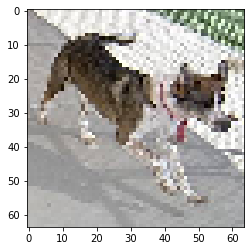

In [6]:
plt.imshow(np.uint8(img_array))

### 1.3. Images to numpy arrays
Now we create training and testing sets for cats and for dogs and then concatenate 2 sets into a single `X_train` dataset of features.

In [7]:
d = 64
X_train_orig = np.zeros((8000, d, d, 3), dtype='float32')
for i in range(4000):    
    path = train_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)

for i in range(4000,8000):    
    path = train_dogs_files[i-4000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)    

    X_test_orig = np.zeros((2000, d, d, 3), dtype='float32')

for i in range(1000):
    img = preprocessing.image.load_img(test_cats_files[i], target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)
    
for i in range(1000, 2000):
    img = preprocessing.image.load_img(test_dogs_files[i-1000], target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)

print(X_train_orig.shape)
print(X_test_orig.shape)

(8000, 64, 64, 3)
(2000, 64, 64, 3)


### 1.4. Normalize image array

In [8]:
X_train = X_train_orig / 255.0
X_test = X_test_orig / 255.0
print(X_train.shape)
print(X_test.shape)

(8000, 64, 64, 3)
(2000, 64, 64, 3)


### 1.5. Create class labels
Now we need to create the corresponding class label vectors. We will mark the cats as class 1, and the dogs as class 0 (not cats).

In [10]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

Y_train_orig = np.ones((4000,)) # 1 - 4000 are cat pictures so our label is 1
Y_train_orig = np.concatenate((Y_train_orig, np.zeros((4000,)))) # 4000 - 8000 are dog pictures so our label is 0
Y_train = Y_train_orig.reshape(-1)
print("At position 3 should be a cat:", Y_train[3])
print("At position 4002 should be a dog:", Y_train[4002])

Y_train = to_categorical(Y_train, num_classes = 2)

print(Y_train.shape)

Y_test_orig = np.ones((1000,))
Y_test_orig = np.concatenate((Y_test_orig, np.zeros((1000,)))) 
Y_test = Y_test_orig.reshape(-1)
Y_test = to_categorical(Y_test, num_classes = 2)

print(Y_test.shape)

At position 3 should be a cat: 1.0
At position 4002 should be a dog: 0.0
(8000, 2)
(2000, 2)


### 1.6 Build CNN Model
model structure: conv => max pool => dropout => conv => max pool => dropout => fully connected (2 layer)


In [32]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [33]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [34]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [35]:
# Fit the model
epochs = 15
batch_size = 250

history = model.fit(X_train,Y_train, epochs = epochs, validation_data = (X_test,Y_test), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/15
32/32 [==============================] - 10s 313ms/step - loss: 0.7306 - accuracy: 0.5217 - val_loss: 0.6891 - val_accuracy: 0.5285
Epoch 2/15
32/32 [==============================] - 11s 333ms/step - loss: 0.6805 - accuracy: 0.5685 - val_loss: 0.6672 - val_accuracy: 0.6225
Epoch 3/15
32/32 [==============================] - 10s 312ms/step - loss: 0.6552 - accuracy: 0.6112 - val_loss: 0.6473 - val_accuracy: 0.6180
Epoch 4/15
32/32 [==============================] - 10s 313ms/step - loss: 0.6330 - accuracy: 0.6405 - val_loss: 0.6392 - val_accuracy: 0.6555
Epoch 5/15
32/32 [==============================] - 10s 314ms/step - loss: 0.6114 - accuracy: 0.6644 - val_loss: 0.6004 - val_accuracy: 0.6825
Epoch 6/15
32/32 [==============================] - 10s 314ms/step - loss: 0.5976 - accuracy: 0.6817 - val_loss: 0.5876 - val_accuracy: 0.6995
Epoch 7/15
32/32 [==============================] - 10s 319ms/step - loss: 0.5823 - accuracy: 0.6988 - val_loss: 0.5966 - val_accuracy: 0.6785

### 1.7. Evaluate the model

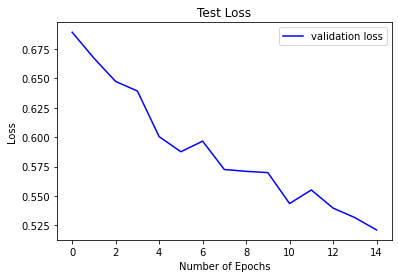

In [36]:
# visualize the loss function
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

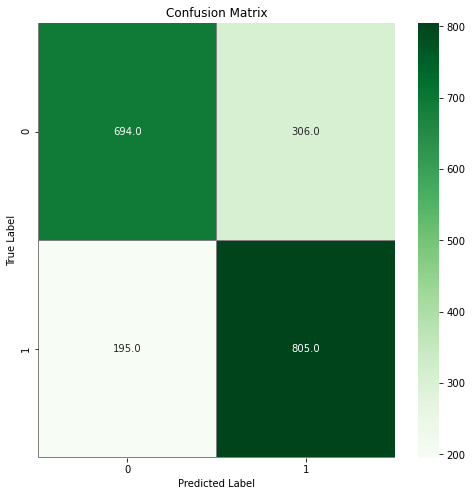

In [37]:
# compute the confusion matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### 1.8 Predict the new image

[[0.8683024  0.13169761]
 [0.24792081 0.7520791 ]]


<Figure size 432x288 with 0 Axes>

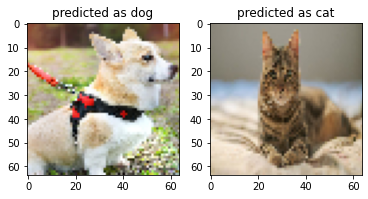

In [39]:
# predict random image of cat and dog
d = 64

test_dir = "./"
test_path_files = []
for path in os.listdir(test_dir):
    if ".jpg" in path:
        test_path_files.append(os.path.join(test_dir,path))

img_arr = np.zeros((2, d, d, 3), dtype='float32')
for i in range(2):
    img = preprocessing.image.load_img(test_path_files[i], target_size=(d, d))
    img_arr[i] = preprocessing.image.img_to_array(img)

X_new = img_arr / 255
Y_new = model.predict(X_new)
print(Y_new)
Y_new_classes = np.argmax(Y_new,axis = 1) 

display = ['dog','cat']
%matplotlib inline

plt.figure()
f, axarr = plt.subplots(1,2) 

for i in range(2):
    axarr[i].imshow(np.uint8(img_arr[i]))
    axarr[i].set_title("predicted as "+display[int(Y_new_classes[i])])